# IOTA 101: Transactions
A transaction is a smallest piece of data that can be broadcasted to the network. Each transaction consists of fixed 2673 trytes. Transactions (TXs) are basically of two types:
* **Value TXs:** those transactions change ownership of IOTA tokens. Two possible states: spending TXs or receiving TXs
* **Non-Value TXs:** those transactions include piece of data that can be broadcasted and read from the Tangle

Transactions are broadcasted in an envelope called *Bundle*. Bundle may consist of multiple TXs. Bundle is processed by the Tangle as a single entity; meaning only the whole bundle is confirmed by the network (and all TXs within) or nothing. You have to prepare a bundle even if you broadcast single transaction only. Bundle is also described as *atomic* since every bundle includes all information needed to process it antonomously.

Each transaction includes several fields, let's name the most important ones:
* **`Value`:** Value can be *positive* number = receiving IOTA tokens, *negative* number = spending IOTA tokens or *zero* = broadcasting only piece of data
* **`Address`:** It is IOTA address that is associated with the given transaction. *Value* indicates whether it is an address of a receiver or a sender
* **`Tag`:** It is an user-defined tag that can be used for searching, etc.
* **`SignatureMessageFragment`:** This is the most lenghty attribute (2187 trytes) and could include: *transaction signature* based on private key in case it is a spending TX or *piece of data (message)* in case it is non-value TX. Alternatively it can be also left blank (in case of non-value TXs)
* **`tTrunkTransaction` / `branchTransaction`:** Those two fields refer to some previous transactions in the Tangle (tips) that the given bundle is going to approve
* **`Timestamp`**
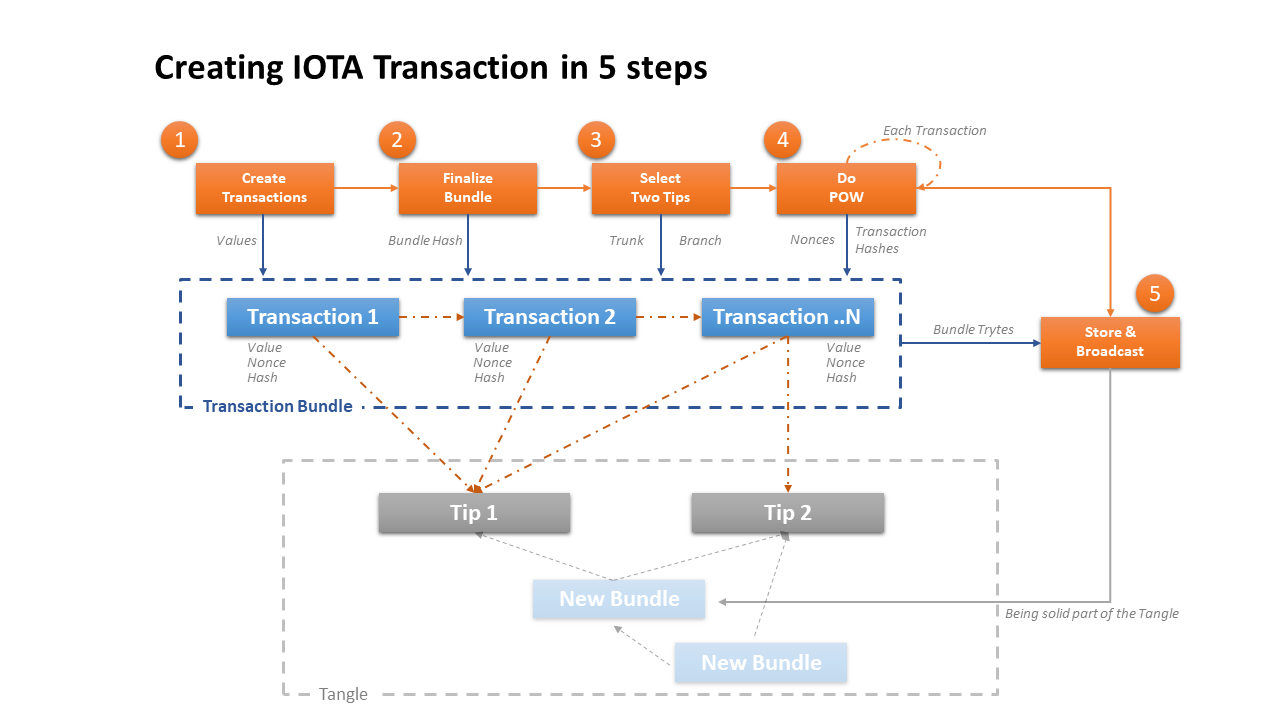

A process of sending IOTA transaction can be summarized in 5 steps:
* To create transation(s) with the given attributes: *value*, *address* and potentially also *tag* or *message*
* To finalize a bundle that includes all transactions. Once the bundle is finalized no new transactions can be added. It basically means to generate a *bundle hash*
* To search for two tips in the Tangle that you are going to validate. There is not a strict rule how to search them but it is generally recommended to leave it on a *tip selection algorithm* implemented on node's side 
* To do a *Proof-of-Work* for each transaction in the bundle. Result of POW is *Nonce* and *Transaction hash* stored with each transaction
* Finally you need to *broadcast* the whole bundle to the network

### A secret of one bundle
There is a secret to be shared. You have to understand one important thing. Bundle is a top level construct that link all related transactions under one entity however the bundle itself is not broadcasted in fact. You still broadcast "only" collection of individual transactions instead. All transactions are recognized to be part of a bundle by the IOTA protocol however any data peering is based on individual transactions (in trytes).

In other words, a bundle can be reconstructed anytime from a collection of transactions via fields `bundle hash`, `current index` and `last index`.

## Non-value transactions
Let's start with non-value transactions first since they are a bit easier for starters.

*Please note, the chapter is divided in two separate sections. In the first section, examples are really close to bare metal (still not too close:) to illustrate the whole process and describing implementation details wherever possible. It is also useful when you want to experiment with different settings at each step (hey "non-existing tips", looking at you).*

*In the second section, PyOTA library is fully levearged since it is capable to hide all implementation details behind a curtain. Needless to say, if you are not interested in such details then you probably would like to start with the second section.*

### Creating and broadcasting transaction in 5 steps (you want to understand the process)
#### Create a transaction
First of all let's create transactions (offline; in memory) and set main fields.

BTW: `Timestamp` field is defined automatically by the PyOTA library and so please make sure it is also defined while using other IOTA-facing libraries. It is an important field while creating `bundle hash`.

In the examples within this chapter we are going to broadcast meta transactions (data only) to two different IOTA addresses.

In [2]:
import iota
from datetime import datetime
from pprint import pprint

MySeed = b"HGW9HB9LJPYUGVHNGCPLFKKPNZAIIFHZBDHKSGMQKFMANUBASSMSV9TAJSSMPRZZU9SFZULXKJ9YLAIUA"
TargetAddress1 = b"CXDUYK9XGHC9DTSPDMKGGGXAIARSRVAFGHJOCDDHWADLVBBOEHLICHTMGKVDOGRU9TBESJNHAXYPVJ9R9"
TargetAddress2 = b"CYJV9DRIE9NCQJYLOYOJOGKQGOOELTWXVWUYGQSWCNODHJAHACADUAAHQ9ODUICCESOIVZABA9LTMM9RW"

NowIs = datetime.now() # get a actual date & time - just to have some meaningfull info

# preparing transactions
pt = iota.ProposedTransaction(address = iota.Address(TargetAddress1), # 81 trytes long address
                              message = iota.TryteString.from_unicode('Here comes a first message. Now is %s' % (NowIs)),
                              tag     = iota.Tag(b'HRIBEK999IOTA999TUTORIAL'), # Up to 27 trytes
                              value   = 0)

pt2 = iota.ProposedTransaction(address = iota.Address(TargetAddress2), # 81 trytes long address
                               message = iota.TryteString.from_unicode('Here comes a second message. Now is %s' % (NowIs)),
                               tag     = iota.Tag(b'HRIBEK999IOTA999TUTORIAL'), # Up to 27 trytes
                               value   = 0)
# besides the given attributes, library also adds a transaction timestamp

print("Created transaction objects:\n")
pprint(vars(pt))
print("\n")
pprint(vars(pt2))

Created transaction objects:

{'_legacy_tag': None,
 'address': Address(b'CXDUYK9XGHC9DTSPDMKGGGXAIARSRVAFGHJOCDDHWADLVBBOEHLICHTMGKVDOGRU9TBESJNHAXYPVJ9R9'),
 'attachment_timestamp': 0,
 'attachment_timestamp_lower_bound': 0,
 'attachment_timestamp_upper_bound': 0,
 'branch_transaction_hash': TransactionHash(b'999999999999999999999999999999999999999999999999999999999999999999999999999999999'),
 'bundle_hash': None,
 'current_index': None,
 'hash': None,
 'is_confirmed': None,
 'last_index': None,
 'message': TryteString(b'RBTCFDTCEARCCDADTCGDEAPCEAUCXCFDGDHDEAADTCGDGDPCVCTCSAEAXBCDKDEAXCGDEAWAUAVABBRAUA9BRAWAABEAUA9BDBWAZADBZACBSAXAVAABXAABWA'),
 'nonce': Nonce(b'999999999999999999999999999'),
 'signature_message_fragment': None,
 'tag': Tag(b'HRIBEK999IOTA999TUTORIAL999'),
 'timestamp': 1530080759,
 'trunk_transaction_hash': TransactionHash(b'999999999999999999999999999999999999999999999999999999999999999999999999999999999'),
 'value': 0}


{'_legacy_tag': None,
 'address': Address(b

#### Finalizing bundle
Once all individual transactions are created it is time to prepare and finalize the bundle. While preparing the bundle you need at least to specify list of prepared transaction(s). In case of non-value transactions it is quite straightforward process. However, it is a bit more complicated in case of value transactions - please see later.

Finalizing the bundle consists of several tasks under the hood:
* Each transaction is indexed. Attributes `current_index` / `last_index` are set
* `Bundle hash` is generated (*Sponge function* + normalization) and assigned to each transaction
* `signatureMessageFragment` is bascially copy of `message` field in case of non-value transactions
* PyOTA library also checks whether the data in `message` field is larger than transaction allows (2187 trytes). If this is the case then it takes care of it and split your data into several transactions

*Please note, finalizing the bundle also means you are no longer able to add new transactions to the bundle post the finalization process.*

Simply put, `bundle hash` is a cryptographic "fingerprint" of all transactions in the bundle. It uniquely represents them and so as long as transactions are the same (incl their particular order) the `bundle hash` is also the same.

$$BundleHash = fce(address, value, legacy tag, timestamp, current index, last index)$$

You may be wondering what is a difference between `tag` and `legacy_tag`. `Tag` includes actualy the tag that was defined during the transaction creation. `Legacy_tag` is also based on it however it is modified during the normalization process while bundle hashing to be sure that `bundle hash` is can be securely used while TX signing. That's why the `bundle hash` is sometimes refered as `normalized bundle hash`.

The bundle refers to the first transaction in collection as `tail_transaction`.

In [5]:
# preparing bundle that consists of both transactions prepared in the previous example
pb = iota.ProposedBundle(transactions=[pt,pt2]) # list of prepared transactions is needed at least

# generate bundle hash using sponge/absorb function + normalize bundle hash + copy bundle hash into each transaction / bundle is finalized
pb.finalize()

#bundle is finalized, let's print it
print("\nGenerated bundle hash: %s" % (pb.hash))
print("\nTail Transaction in the Bundle is a transaction #%s." % (pb.tail_transaction.current_index))
        
print("\nList of all transactions in the bundle:\n")
for txn in pb:
    pprint(vars(txn))
    print("")



Generated bundle hash: TL9EHBGBIDCTLCARLPKBSUQIG9CKQPDGTLOVNLG9TALAGEWQRBEK9DPLDDBGOAZIREKGYPYFCWJCTOADW

Tail Transaction in the Bundle is a transaction #0.

List of all transactions in the bundle:

{'_legacy_tag': Tag(b'PVIBEK999IOTA999TUTORIAL999'),
 'address': Address(b'CXDUYK9XGHC9DTSPDMKGGGXAIARSRVAFGHJOCDDHWADLVBBOEHLICHTMGKVDOGRU9TBESJNHAXYPVJ9R9'),
 'attachment_timestamp': 0,
 'attachment_timestamp_lower_bound': 0,
 'attachment_timestamp_upper_bound': 0,
 'branch_transaction_hash': TransactionHash(b'999999999999999999999999999999999999999999999999999999999999999999999999999999999'),
 'bundle_hash': BundleHash(b'TL9EHBGBIDCTLCARLPKBSUQIG9CKQPDGTLOVNLG9TALAGEWQRBEK9DPLDDBGOAZIREKGYPYFCWJCTOADW'),
 'current_index': 0,
 'hash': None,
 'is_confirmed': None,
 'last_index': 1,
 'message': TryteString(b'RBTCFDTCEARCCDADTCGDEAPCEAUCXCFDGDHDEAADTCGDGDPCVCTCSAEAXBCDKDEAXCGDEAWAUAVABBRAUA9BRAWAABEAUA9BDBWAZADBZACBSAXAVAABXAABWA'),
 'nonce': Nonce(b'999999999999999999999999999'),
 'signat

At this stage you can also see how does our finalized bundle look encoded in Trytes so far. It is also a proof that there is no bundle to be broadcasted itself, only list of transations matter.

In [6]:
Trytes = pb.as_tryte_strings() # bundle as trytes
pprint(Trytes)


[TransactionTrytes(b'RBTCFDTCEARCCDADTCGDEAPCEAGDTCRCCDBDSCEAADTCGDGDPCVCTCSAEAXBCDKDEAXCGDEAWAUAVABBRAUA9BRAWAABEAUA9BDBWAZADBZACBSAXAVAABXAABWA999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999

#### Selecting two tips
As mentioned earlier you need to find two tips that you are going to validate together with your bundle for a sake of network participation. This will be outsourced to an IOTA node and so it will be for the first time we interact with the network (via API call `get_transactions_to_approve`).

There is a `depth` parameter needed. It instructs a node how many milestones it should go in the past while confirming tips. The higher value the better to network however more resources needed. `Depth=3` is considered to be well-balanced compromise.

It should return two selected tips as `branch` and `trunk` transactions. Those transactions will be used while broadcasting the bundle.

In [7]:
api = iota.Iota("https://field.carriota.com:443") # selecting IOTA node via Field service

gta = api.get_transactions_to_approve(depth=3) # get tips to be approved by your bundle
pprint(gta)



{'branchTransaction': TransactionHash(b'KQBDDBHWHVLQSJFENGWRBHIOULOMC9GXDW99ECMVFHZXGFZQJOXATSMDLYQJFBZCXA9IJ9SQUXAFZ9999'),
 'duration': 1700,
 'fieldName': 'F-Node Montabaur',
 'fieldPublicId': '1bdeeb759f960554',
 'fieldVersion': '0.1.6',
 'trunkTransaction': TransactionHash(b'RRYDZLPS9IWCSWRROPQQJTKBRONOJNLUHVHFXFEOZAVGFEOUAHXWWHJSHAGWSSNSMWHN9SEYNBOEA9999')}


#### Performin' POW
*Proof of work* is a relatively simple cryptograhic puzzle to be solved. It represents energy-based costs of your transaction. It also helps to minimize risks of some attack vectors to the network.

This task can be also outsourced to IOTA nodes. In order to perform it you need *selected tips*, *finalized bundle* (in trytes) and also `Minimum Weight Magnitude` parameter. This parameter defines how diffciult the given cryptographic puzzle should be to be accepted by the network. As of now, you should set at least `min_weight_magnitude=14` in case of mainnet.

Please note, POW is performed per each transaction and so it can take some time. That's why it is not recommended to have more than 30 transactions in a bundle.

Once succesfully performed, the modified bundle (list of all transactions in trytes) is returned in order to be broadcasted.

Specifically:
* Fields `nonce` and `transaction hash` are calculated per each transaction
* `Trunk` and `Branch` tips are correctly mapped among transactions within the bundle. Check that `trunk` of the first TX refers to the second TX, etc.

In [8]:
print("Performing POW... Wait please...\n")
att = api.attach_to_tangle(trunk_transaction=gta['trunkTransaction'], # first tip selected
                           branch_transaction=gta['branchTransaction'], # second tip selected
                           trytes=Trytes, # our finalized bundle in Trytes
                           min_weight_magnitude=14) # MWMN
pprint(att)

Performing POW... Wait please...

{'duration': 12267,
 'fieldName': 'iota-fn01.sairai.de',
 'fieldPublicId': '45f52c5a2e829a00',
 'fieldVersion': '0.1.6',
 'trytes': [TransactionTrytes(b'RBTCFDTCEARCCDADTCGDEAPCEAUCXCFDGDHDEAADTCGDGDPCVCTCSAEAXBCDKDEAXCGDEAWAUAVABBRAUA9BRAWAABEAUA9BDBWAZADBZACBSAXAVAABXAABWA9999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999

You can eventually also preview what specific fields have been modified using transaction objects. The bundle is ready to be broadcasted and so it also show you all fields/values that will be stored in the network.

In [10]:
# show what has been broadcasted - hash transaction + nonce (POW)
print("Final bundle including POW and branch/trunk transactions:\n")
for t in att['trytes']:
    pprint(vars(iota.Transaction.from_tryte_string(t)))
    print("")

Final bundle including POW and branch/trunk transactions:

{'_legacy_tag': Tag(b'PVIBEK999IOTA999TUTORIAL999'),
 'address': Address(b'CXDUYK9XGHC9DTSPDMKGGGXAIARSRVAFGHJOCDDHWADLVBBOEHLICHTMGKVDOGRU9TBESJNHAXYPVJ9R9'),
 'attachment_timestamp': 1530081729891,
 'attachment_timestamp_lower_bound': 0,
 'attachment_timestamp_upper_bound': 12,
 'branch_transaction_hash': TransactionHash(b'RRYDZLPS9IWCSWRROPQQJTKBRONOJNLUHVHFXFEOZAVGFEOUAHXWWHJSHAGWSSNSMWHN9SEYNBOEA9999'),
 'bundle_hash': BundleHash(b'TL9EHBGBIDCTLCARLPKBSUQIG9CKQPDGTLOVNLG9TALAGEWQRBEK9DPLDDBGOAZIREKGYPYFCWJCTOADW'),
 'current_index': 0,
 'hash': TransactionHash(b'SYDECKQB9BHWFUYOZMANREHOCXHCOPY9JCSZSNIZRNDJTZXHHSESCCLQOENGRVFLDMNXYAHHEWRDZ9999'),
 'is_confirmed': None,
 'last_index': 1,
 'nonce': Nonce(b'QRZIERPEJFLKTIVKEBQIHJXTAX9'),
 'signature_message_fragment': Fragment(b'RBTCFDTCEARCCDADTCGDEAPCEAUCXCFDGDHDEAADTCGDGDPCVCTCSAEAXBCDKDEAXCGDEAWAUAVABBRAUA9BRAWAABEAUA9BDBWAZADBZACBSAXAVAABXAABWA9999999999999999999999999999

#### Broadcasting
Now it is time to broadcast the given bundle to the network. List of all transations in trytes returned from the previous step is only thing needed.

Once succesfully broadcasted it returns the same input bundle as a confirmation.

You can check the broadcasted bundle via The Tangle Explorer at any of the receiving addresses:
* Target address 1: https://thetangle.org/address/CXDUYK9XGHC9DTSPDMKGGGXAIARSRVAFGHJOCDDHWADLVBBOEHLICHTMGKVDOGRU9TBESJNHAXYPVJ9R9
* Target address 2: 
https://thetangle.org/address/CYJV9DRIE9NCQJYLOYOJOGKQGOOELTWXVWUYGQSWCNODHJAHACADUAAHQ9ODUICCESOIVZABA9LTMM9RW


In [11]:
print("Broadcasting transaction...")
res = api.broadcast_and_store(att['trytes'])
pprint(res)

Broadcasting transaction...
{'trytes': [TransactionTrytes(b'RBTCFDTCEARCCDADTCGDEAPCEAUCXCFDGDHDEAADTCGDGDPCVCTCSAEAXBCDKDEAXCGDEAWAUAVABBRAUA9BRAWAABEAUA9BDBWAZADBZACBSAXAVAABXAABWA99999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999

### Creating and broadcasting transaction in a single call (you want send a transaction quickly)
As mentioned above, PyOTA library (and almost any other IOTA-facing library) is able to encapsulate all implementation details and so you do not need to care of them anymore. It is usually based on *extended API calls* that were proposed to be included by IOTA Foundation to make developer's life easier (https://github.com/iotaledger/wiki/blob/master/api-proposal.md).

Even if using extended API calls you can still slightly control a level of your involvement in the whole process:

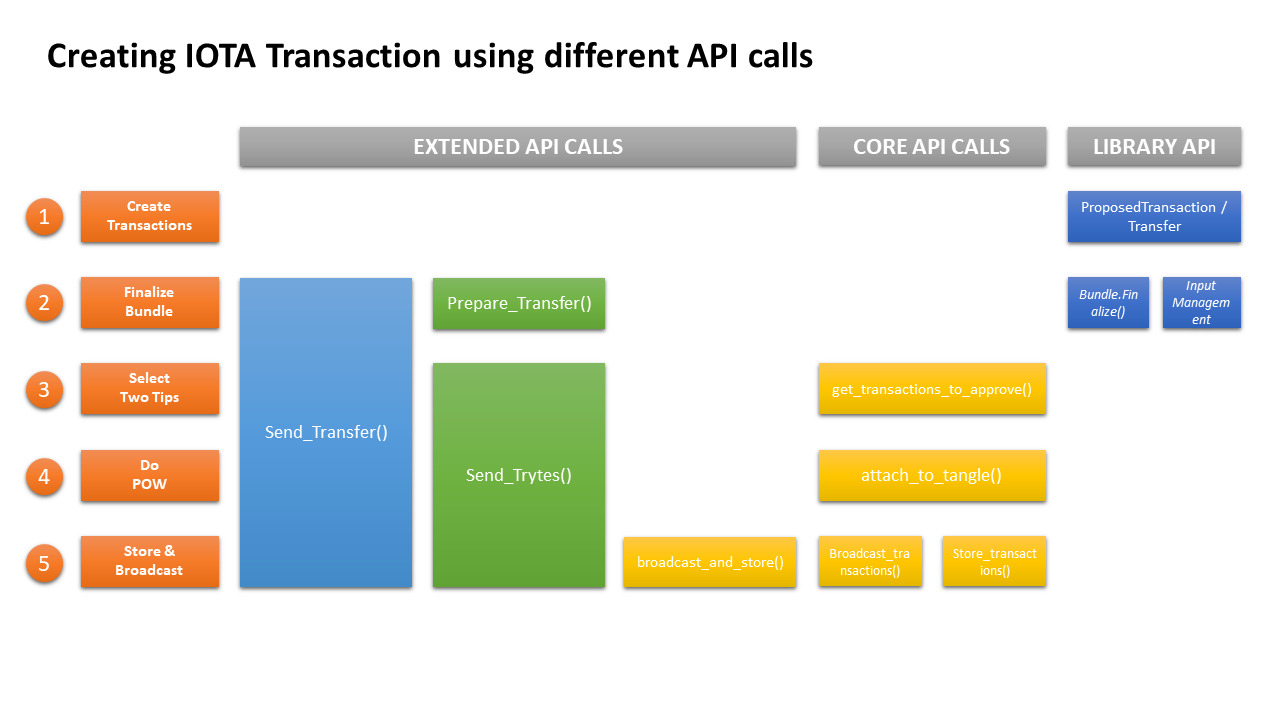

There are some specifics you should consider while designing your app:
* You are loosing a bit of control of individual steps of the process and you have to rely of some predefined parameters (tip selection algo, etc.)
* If there is an exception raised during the process then you need to go back at beginning and restart the whole process again

So it is basically your call to decide what works best for you.

Now back to our exercise.

Here comes the code that basically broadcasts transactions in a single call (send_transfer()) and you do not have to care of any implemenation details that are hidden under the hood.

In [16]:
import iota
from datetime import datetime
from pprint import pprint

MySeed = b"HGW9HB9LJPYUGVHNGCPLFKKPNZAIIFHZBDHKSGMQKFMANUBASSMSV9TAJSSMPRZZU9SFZULXKJ9YLAIUA"
TargetAddress1 = b"CXDUYK9XGHC9DTSPDMKGGGXAIARSRVAFGHJOCDDHWADLVBBOEHLICHTMGKVDOGRU9TBESJNHAXYPVJ9R9"
TargetAddress2 = b"CYJV9DRIE9NCQJYLOYOJOGKQGOOELTWXVWUYGQSWCNODHJAHACADUAAHQ9ODUICCESOIVZABA9LTMM9RW"

NowIs = datetime.now() # get a actual date & time - just to have some meaningfull info

# preparing transactions
pt = iota.ProposedTransaction(address = iota.Address(TargetAddress1), # 81 trytes long address
                              message = iota.TryteString.from_unicode('Here comes a first message. Now is %s' % (NowIs)),
                              tag     = iota.Tag(b'HRIBEK999IOTA999TUTORIAL'), # Up to 27 trytes
                              value   = 0)

pt2 = iota.ProposedTransaction(address = iota.Address(TargetAddress2), # 81 trytes long address
                               message = iota.TryteString.from_unicode('Here comes a second message. Now is %s' % (NowIs)),
                               tag     = iota.Tag(b'HRIBEK999IOTA999TUTORIAL'), # Up to 27 trytes
                               value   = 0)
# besides the given attributes, library also adds a transaction timestamp


api = iota.Iota("https://field.carriota.com:443")

print("Preparing/Broadcasting... Wait please...")
# the whole process initiated in a single call
FinalBundle = api.send_transfer(depth=3,
                                transfers=[pt,pt2],
                                min_weight_magnitude=14)['bundle'] # it returns a dictionary with a bundle object
    
#bundle is broadcasted, let's print it
print("\nGenerated bundle hash: %s" % (FinalBundle.hash))
print("\nTail Transaction in the Bundle is a transaction #%s." % (FinalBundle.tail_transaction.current_index))
        
print("\nList of all transactions in the bundle:\n")
for txn in FinalBundle:
    pprint(vars(txn))
    print("")

Preparing/Broadcasting... Wait please...

Generated bundle hash: BUNIIHDTRGQYDBWHCELXHFXLUI9NJEGADGXDHHZIKIRULELTKVPTQJH9LJRVLBNVIIZKZJAGKRPHVQJAB

Tail Transaction in the Bundle is a transaction #0.

List of all transactions in the bundle:

{'_legacy_tag': Tag(b'GVIBEK999IOTA999TUTORIAL999'),
 'address': Address(b'CXDUYK9XGHC9DTSPDMKGGGXAIARSRVAFGHJOCDDHWADLVBBOEHLICHTMGKVDOGRU9TBESJNHAXYPVJ9R9'),
 'attachment_timestamp': 1530093517465,
 'attachment_timestamp_lower_bound': 0,
 'attachment_timestamp_upper_bound': 12,
 'branch_transaction_hash': TransactionHash(b'NEVBYHEKVOARHWETDYOBAJGWYQRTPH9Y9MJSRNPPYYSXGLLQECPLTSTFTJNUMTCQUPXLMYQ99FTNZ9999'),
 'bundle_hash': BundleHash(b'BUNIIHDTRGQYDBWHCELXHFXLUI9NJEGADGXDHHZIKIRULELTKVPTQJH9LJRVLBNVIIZKZJAGKRPHVQJAB'),
 'current_index': 0,
 'hash': TransactionHash(b'FPGUNFXJGLLYRIBBCMPKGZSCPCQLB9XRWLUKEL9QLOGDTRPSNLRMDKFTNH9ASOCKTBK9XV9OTLQLZ9999'),
 'is_confirmed': None,
 'last_index': 1,
 'nonce': Nonce(b'GCFAMCTYWHMOBXYOUAKKJL9AXKV'),
 'signatu

You can check the broadcasted bundle via The Tangle Explorer at any of the receiving addresses:
* Target address 1: https://thetangle.org/address/CXDUYK9XGHC9DTSPDMKGGGXAIARSRVAFGHJOCDDHWADLVBBOEHLICHTMGKVDOGRU9TBESJNHAXYPVJ9R9
* Target address 2: 
https://thetangle.org/address/CYJV9DRIE9NCQJYLOYOJOGKQGOOELTWXVWUYGQSWCNODHJAHACADUAAHQ9ODUICCESOIVZABA9LTMM9RW